In [24]:
import os.path as op
import matplotlib.pyplot as plt
from itertools import compress
import time
import logging
import mne
from mne import events_from_annotations
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from itertools import compress
import mne
import mne_nirs
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from mne_nirs.signal_enhancement import enhance_negative_correlation, short_channel_regression

from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair,
                                    scalp_coupling_index)

import ROI
from ROI import different_hb
from meta import *
from filter_params import FILTER_DICT
from functions_fnirs import *


fnirs_colors = dict(
  hbo='#C91111',
  hbr='#004E7C',
  hbt= '#5B324B')


In [3]:
def make_topo_arrays(smr_epochs, rest_epochs, hb_type, window=None):
    
    if hb_type == 'hbr' or hb_type=='hbo':
        smr_topos = smr_epochs.copy().pick(fnirs=hb_type)
        rest_topos = rest_epochs.copy().pick(fnirs=hb_type)
        
        smr_topos_mean = smr_topos.mean(axis=0)
        rest_topos_mean = rest_topos.mean(axis=0)
        
        return smr_topos_mean, rest_topos_mean
    
    elif hb_type == 'hbt':
        smr_topos_hbo = smr_epochs.copy().pick(fnirs='hbo')
        rest_topos_hbo = rest_epochs.copy().pick(fnirs='hbo')
        smr_topos_hbr = smr_epochs.copy().pick(fnirs='hbr')
        rest_topos_hbr = rest_epochs.copy().pick(fnirs='hbr') 
        
        smr_topos_hbt = smr_topos_hbo + smr_topos_hbr
        rest_topos_hbt = rest_topos_hbo + rest_topos_hbr
        
        smr_topos_hbt_mean = smr_topos_hbt.mean(axis=0)
        rest_topos_hbt_mean = rest_topos_hbt.mean(axis=0)
        
        return smr_topos_hbt_mean, rest_topos_hbt_mean
    
    elif hb_type == 'rel_hbo' and window:
        smr_topos_hbo = smr_epochs.copy().pick(fnirs='hbo')
        rest_topos_hbo = rest_epochs.copy().pick(fnirs='hbo')
        smr_topos_mean = smr_topos_hbo.mean(axis=0)
        rest_topos_mean = rest_topos_hbo.mean(axis=0)
        
        smr_ref = np.median(smr_topos_mean[:, window[0]:window[1]])
        smr_relation_mean = (smr_topos_mean - smr_ref) / smr_ref * -1
        rest_ref = np.median(rest_topos_mean[:, window[0]:window[1]])
        rest_relation_mean = (rest_topos_mean - rest_ref) / rest_ref * -1
        
        return smr_relation_mean, rest_relation_mean
    
    elif hb_type == 'rel_hbr' and window:
        smr_topos_hbr = smr_epochs.copy().pick(fnirs='hbr')
        rest_topos_hbr = rest_epochs.copy().pick(fnirs='hbr')
        smr_topos_mean = smr_topos_hbr.mean(axis=0)
        rest_topos_mean = rest_topos_hbr.mean(axis=0)
        
        smr_ref = np.median(smr_topos_mean[:, window[0]:window[1]])
        smr_relation_mean = (smr_topos_mean - smr_ref) / smr_ref * -1
        rest_ref = np.median(rest_topos_mean[:, window[0]:window[1]])
        rest_relation_mean = (rest_topos_mean - rest_ref) / rest_ref * -1
        
        return smr_relation_mean, rest_relation_mean
    
    
    elif hb_type == 'rel_hbt' and window:
        smr_topos_hbo = smr_epochs.copy().pick(fnirs='hbo')
        rest_topos_hbo = rest_epochs.copy().pick(fnirs='hbo')
        smr_topos_hbr = smr_epochs.copy().pick(fnirs='hbr')
        rest_topos_hbr = rest_epochs.copy().pick(fnirs='hbr') 
        
        smr_topos_hbt = smr_topos_hbo + smr_topos_hbr
        rest_topos_hbt = rest_topos_hbo + rest_topos_hbr
        
        smr_topos_hbt_mean = smr_topos_hbt.mean(axis=0)
        rest_topos_hbt_mean = rest_topos_hbt.mean(axis=0)
        
        smr_ref = np.median(smr_topos_hbt_mean[:, window[0]:window[1]])
        smr_topos_relation_hbt_mean = (smr_topos_hbt_mean - smr_ref) / smr_ref * -1
        rest_ref = np.median(rest_topos_hbt_mean[:, window[0]:window[1]])
        rest_topos_relation_hbt_mean = (rest_topos_hbt_mean - rest_ref) / rest_ref * -1
        
        return smr_topos_relation_hbt_mean, rest_topos_relation_hbt_mean
    
    
def mean_topomap(arr, window=(4, 12)):
    mean_arr = arr[:, window[0]:window[1]].mean(axis=1)
    return mean_arr

Тут начинается код

In [8]:
filename = '/mnt/diskus/fNIRS data ME_MI_TS_TI_SA/AA/AA_TI'

DROP_CHANS = [
 'S2_D4 760',
 'S2_D4 850',]

raw_intensity = mne.io.read_raw_nirx(filename, verbose=False)

raw_od = optical_density(raw_intensity) #from row wavelength data

raw_od_shorts = mne_nirs.channels.get_short_channels(raw_od)
raw_od.drop_channels(DROP_CHANS) #we had a non-existent channel

raw_od = mne_nirs.signal_enhancement.short_channel_regression(raw_od)

raw_od = mne_nirs.channels.get_long_channels(raw_od)
raw_od = temporal_derivative_distribution_repair(raw_od) #repairs movement artifacts

raw_haemo = beer_lambert_law(raw_od, ppf=0.1) #from wavelength to HbO\HbR
raw_haemo = raw_haemo.filter(**FILTER_DICT)
raw_haemo = enhance_negative_correlation(raw_haemo)

######################################
ids_target= 'SMR'
ids_rest = 'REST'

events, ids = events_from_annotations(raw_haemo)
ids[ids_target] = 1
ids[ids_rest] = 2

IDS_TO_POP = ["2.0", "33.0", "1.0", "2", "1", "33"]
ids_to_pop = IDS_TO_POP
for i in ids_to_pop:
    popper(ids, i)
    
tmin = float(-1.5)
tmax = float(15.0)
baseline = (-1.5, 0)

epochs = mne.Epochs(
                    raw=raw_haemo,
                    events=events,
                    event_id=ids,
                    baseline=baseline,
                    tmin=tmin,
                    tmax=tmax,
                    preload=True,
                    verbose=False,
                    # picks=picks
                )
epochs.resample(2)

rest_epochs = epochs['REST']
smr_epochs = epochs['SMR']



Reading 0 ... 6516  =      0.000 ...   640.549 secs...


/tmp/ipykernel_8108/940087328.py:20: RuntimeWarning: filter_length (13429) is longer than the signal (6517), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(**FILTER_DICT)


Used Annotations descriptions: ['1.0', '2.0']


In [9]:
%matplotlib inline

In [13]:
mean_m1_left = M1_evoked_REST_left.mean(axis=0)
mean_m1_left.shape

(33,)

In [10]:
curves_hb = 'hbo'

M1_evoked_SMR_left, M1_evoked_REST_left = make_evokeds_roi(
                                                    smr_epochs=smr_epochs, 
                                                    rest_epochs=rest_epochs,
                                                    pick=different_hb[curves_hb][0])
S1_evoked_SMR_left, S1_evoked_REST_left = make_evokeds_roi(
                                                    smr_epochs=smr_epochs, 
                                                    rest_epochs=rest_epochs,
                                                    pick=different_hb[curves_hb][1])
SMZ_evoked_SMR_left, SMZ_evoked_REST_left = make_evokeds_roi(
                                                    smr_epochs=smr_epochs, 
                                                    rest_epochs=rest_epochs,
                                                    pick=different_hb[curves_hb][2]
                                                    )
###EVOKEDS RIGHT###
M1_evoked_SMR_right, M1_evoked_REST_right = make_evokeds_roi(
                                                    smr_epochs=smr_epochs, 
                                                    rest_epochs=rest_epochs,
                                                    pick=different_hb[curves_hb][3]
                                                    ) 
S1_evoked_SMR_right, S1_evoked_REST_right = make_evokeds_roi(
                                                    smr_epochs=smr_epochs, 
                                                    rest_epochs=rest_epochs,
                                                    pick=different_hb[curves_hb][4]
                                                    )
SMZ_evoked_SMR_right, SMZ_evoked_REST_right = make_evokeds_roi(
                                                    smr_epochs=smr_epochs, 
                                                    rest_epochs=rest_epochs,
                                                    pick=different_hb[curves_hb][5]
                                                    )

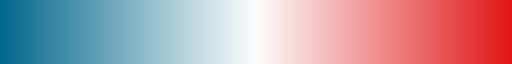

In [11]:
from matplotlib.colors import LinearSegmentedColormap

# Define the color list
color_list = [(0, '#02678c'), (0.5, '#fdfdfd'), (1, '#e11616')]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list('Custom_cmap', color_list, )

custom_cmap

In [750]:
n_times = np.arange(2, 16, 2)
vlim = (-7e-6, 7e-6)

fig, axes = plt.subplots(1, len(n_times), figsize=(20, 12))

cmap = 'hot'
for idx, ax in enumerate(axes):
    
    mne.viz.plot_topomap(data=arr_mean[:, n_times[idx]*2],
                        pos=topo_info,
                        axes=ax,
                        vlim=vlim,
                        contours=0,
                        extrapolate='local',
                        image_interp='cubic',
                        cmap=cmap
                         
                        )
    ax.set_title(f'{n_times[idx]} s')

sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=matplotlib.colors.Normalize(vmin=vlim[0], vmax=vlim[1]))

cbaxes = fig.add_axes([0.075, 0.25, 0.02, 0.5]) # setup colorbar axes. 
cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')

cbar.set_label(' Hb concentration, Δ μM\L', loc='center', size=12)
cbar.ax.yaxis.set_label_coords(-0.5, 0.5)




In [610]:
std_err = np.std(rest_hbo_left_total, axis=0)

In [611]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# m, lower, upper = mean_confidence_interval(rest_hbo_left_total)

lower, upper = smr_mean_hbo_left - std_err, smr_mean_hbo_left + std_err
# confidence_intervals = np.percentile(smr_hbo_left_total, [2.5, 97.5], axis=0)


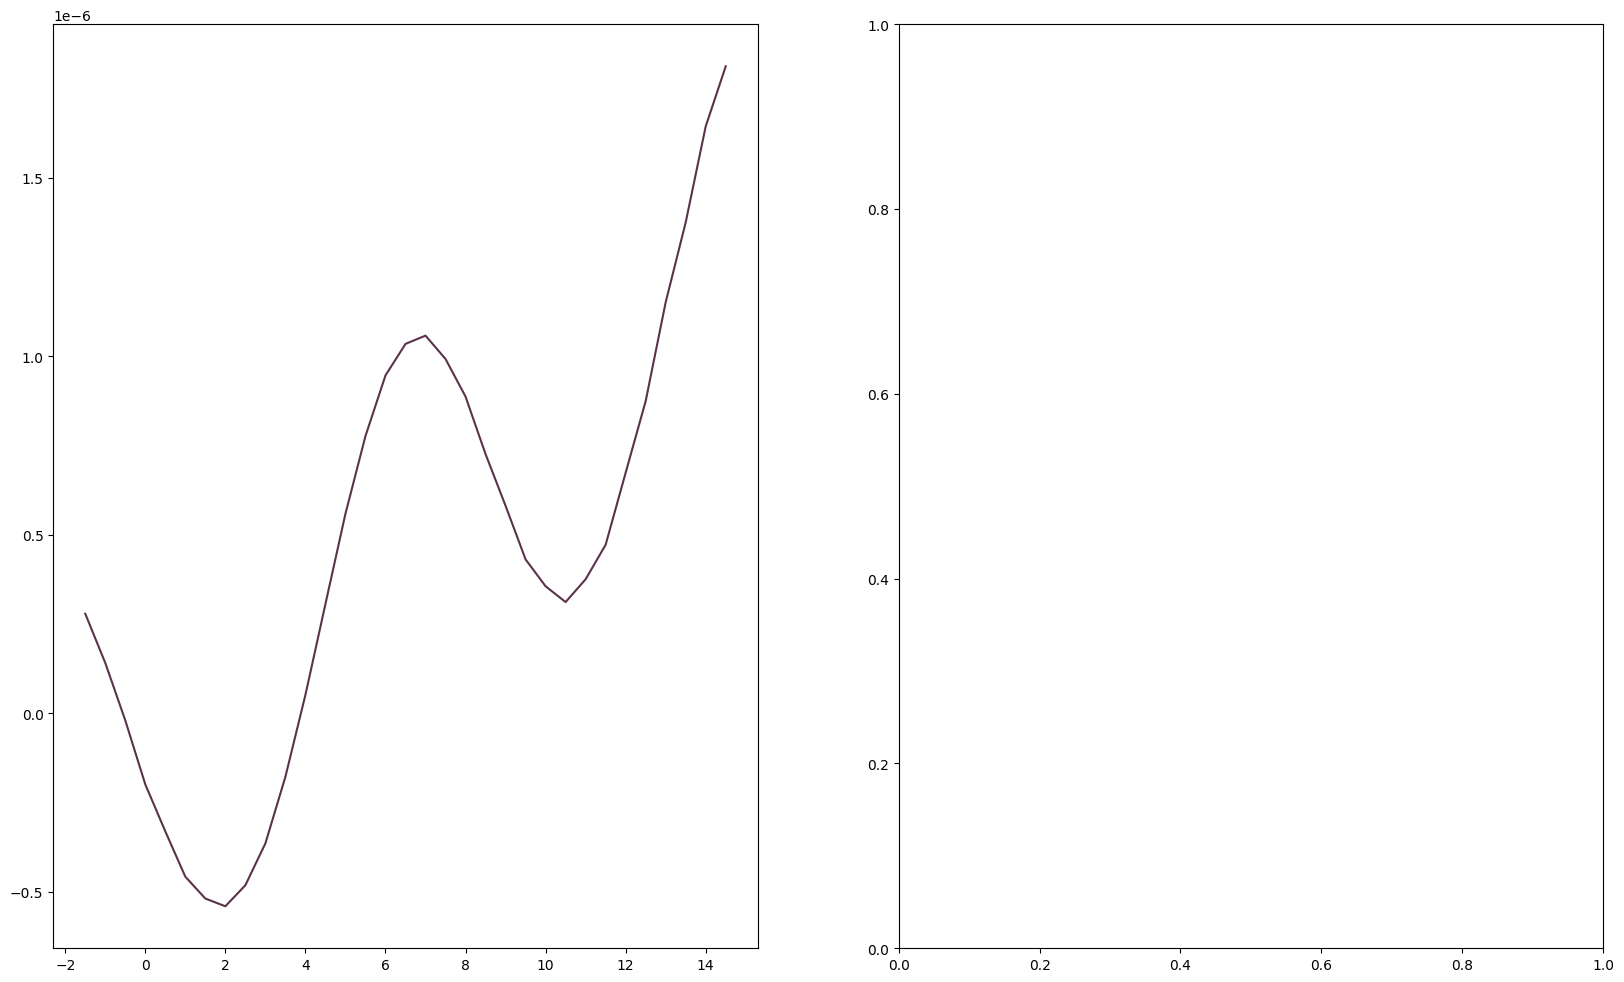

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
times = np.arange(tmin, tmax, 1/2)
linewidth = 1.5
CONDITION = 'ME'

####LEFT PART#############

axes[0].plot(times, mean_m1_left, label=f'{CONDITION}/HbO', 
             color=fnirs_colors['hbt'])


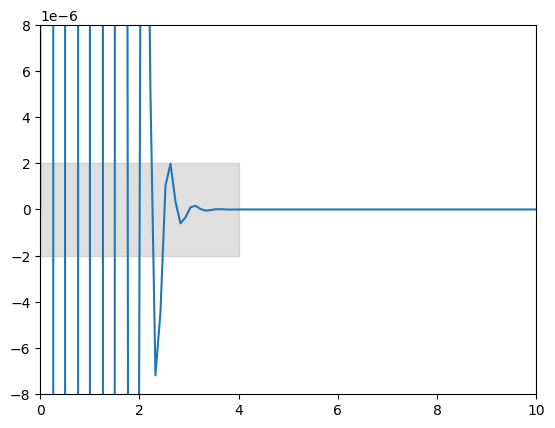

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
x = np.linspace(0, 10, 100)
y = np.sin(4 * np.pi * x) * np.exp(-5 * x)

# Create a plot
fig, ax = plt.subplots()
ax.plot(x, y)

# Add a transparent color block with borders
y_min = -2e-6
y_max = 2e-6
x_min = 0
x_max = 4
ax.fill_between([0, 4], y_min, y_max, color='grey', alpha=0.25)

# Set the y limits
ax.set_ylim(-8e-6, 8e-6)

# Set the x limits
ax.set_xlim(0, 10)

plt.show()

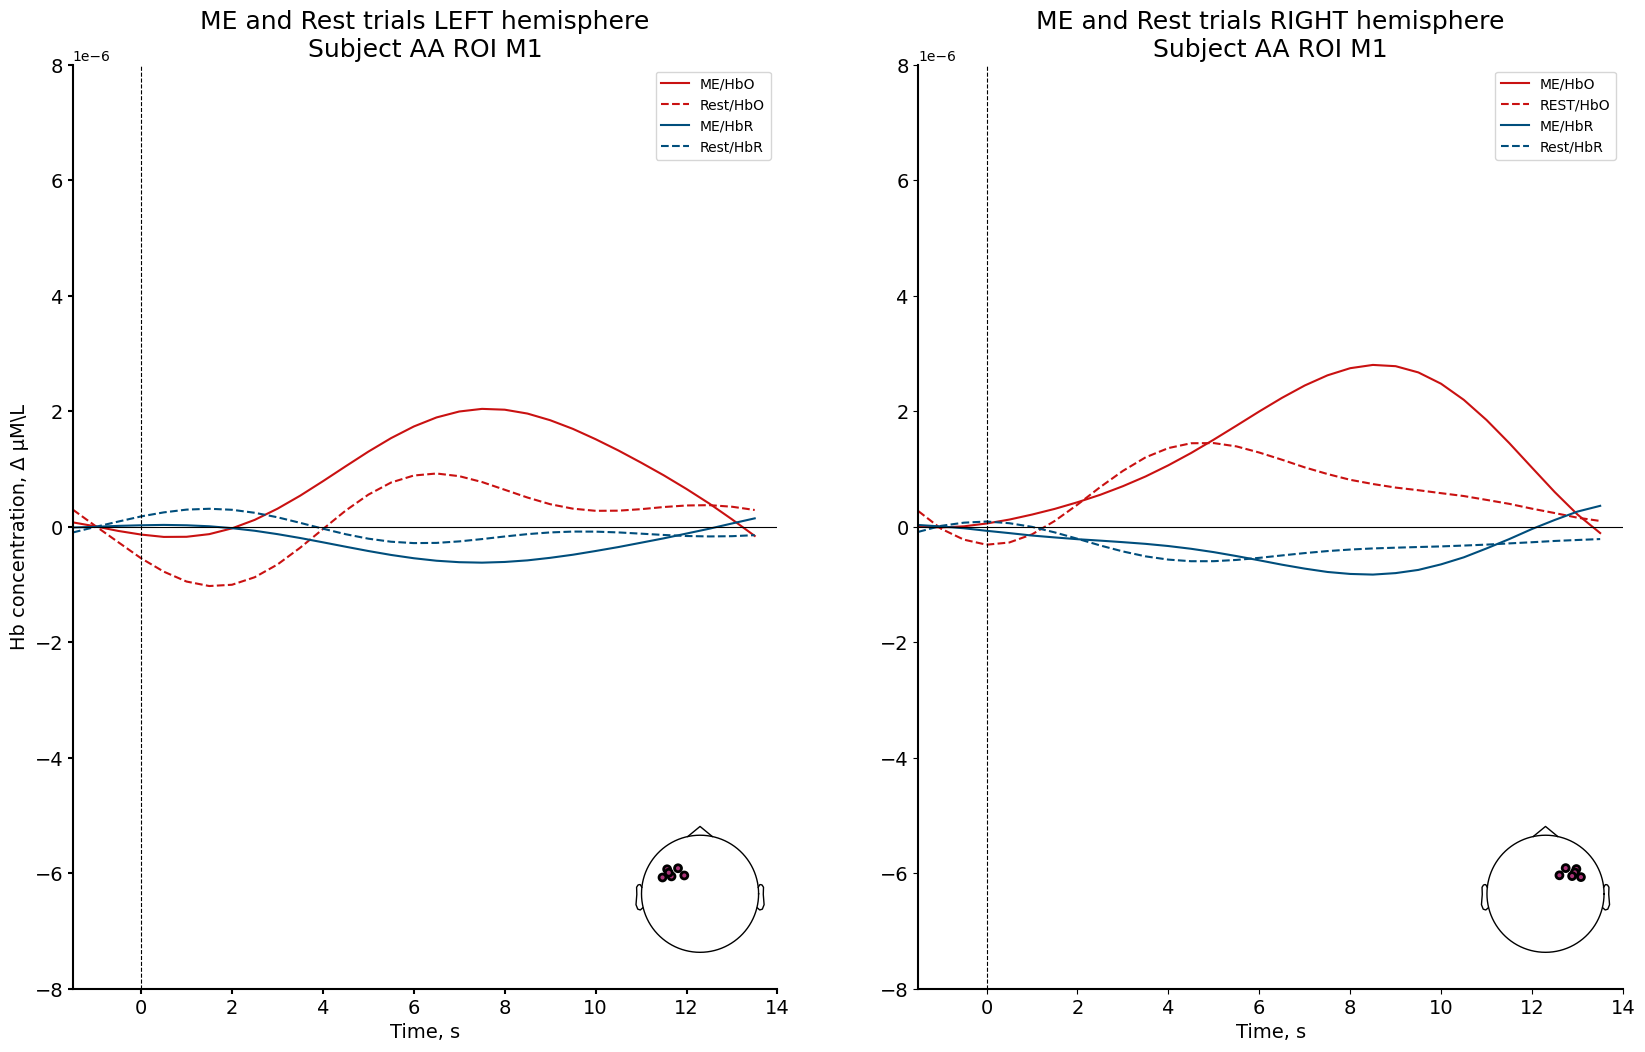

In [612]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

CONDITION = 'ME'
SUBJECT = 'AA'
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
times = np.arange(tmin, tmax, 1/info_left['sfreq'])
linewidth = 1.5

####LEFT PART#############

axes[0].plot(times, smr_mean_hbo_left, label=f'{CONDITION}/HbO', 
             color=porsche_colors['Guards Red'])
axes[0].plot(times, rest_mean_hbo_left, label='Rest/HbO', 
             color=porsche_colors['Guards Red'], 
             linestyle='--')
axes[0].plot(times, smr_mean_hbr_left, label=f'{CONDITION}/HbR', 
             color=porsche_colors['Sapphire Blue'])
axes[0].plot(times, rest_mean_hbr_left, label='Rest/HbR', 
             color=porsche_colors['Sapphire Blue'], 
             linestyle='--')

# axes[0].fill_between(times, lower, upper,
#                      color=porsche_colors['Guards Red'], alpha=0.2)
# axes[0].errorbar(times, smr_mean_hbo_left, 
#                  yerr=[lower, upper], 
#                  fmt='-', 
#                  color=porsche_colors['Guards Red'])

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].legend()

axes[0].set_xlim(tmin, tmax)
axes[0].set_ylim(-8e-6, 8e-6)
axes[0].set_xlabel('Time, s',
                  fontsize=14)
axes[0].tick_params(axis='x', 
               labelsize=14)
axes[0].tick_params(axis='y', 
               labelsize=14)
axes[0].xaxis.set_tick_params(width=linewidth)
axes[0].yaxis.set_tick_params(width=linewidth)
for i in axes[0].spines.values():
   i.set_linewidth(linewidth)
axes[0].set_ylabel('Hb concentration, Δ μM\L',
                  fontsize=14)
linewidth = ax.spines['bottom'].get_linewidth()
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=linewidth)
axes[0].axhline(y=0, color='black', linewidth=linewidth)
axes[0].set_title(f'{CONDITION} and Rest trials LEFT hemisphere\nSubject {SUBJECT} ROI {roi}',
                 fontsize=18)
inset_ax = inset_axes(axes[0], width="20%", height="20%", loc="lower right")
mne.viz.plot_sensors(info=info_left, axes=inset_ax)


####RIGHT PART#############

axes[1].plot(times, smr_mean_hbo_right, label=f'{CONDITION}/HbO', color=porsche_colors['Guards Red'])
axes[1].plot(times, rest_mean_hbo_right, label='REST/HbO', color=porsche_colors['Guards Red'], 
             linestyle='--')
axes[1].plot(times, smr_mean_hbr_right, label=f'{CONDITION}/HbR', color=porsche_colors['Sapphire Blue'])
axes[1].plot(times, rest_mean_hbr_right, label='Rest/HbR', color=porsche_colors['Sapphire Blue'], 
             linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].legend()
axes[1].set_xlim(tmin, tmax)
axes[1].set_ylim(-8e-6, 8e-6)
axes[1].set_xlabel('Time, s',
                  fontsize=14)
axes[1].tick_params(axis='x', 
               labelsize=14)
axes[1].tick_params(axis='y', 
               labelsize=14)
axes[1].xaxis.set_tick_params(width=linewidth)
axes[1].yaxis.set_tick_params(width=linewidth)
for i in axes[1].spines.values():
   i.set_linewidth(1.5)
linewidth = ax.spines['bottom'].get_linewidth()
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=linewidth)
axes[1].axhline(y=0, color='black', linewidth=linewidth)
axes[1].set_title(f'{CONDITION} and Rest trials RIGHT hemisphere\nSubject {SUBJECT} ROI {roi}',
                 fontsize=18)
inset_ax = inset_axes(axes[1], width="20%", height="20%", loc="lower right")
mne.viz.plot_sensors(info=info_right, axes=inset_ax)

